### Convolutional Neural Networks
Convolutional Neural Networks are very similar to feed forward Neural Networks They are made up of neurons that have learnable weights and biases. Each neuron receives some inputs, performs a dot product and optionally follows it with a non-linearity. The whole network still expresses a single differentiable score function: from the raw image pixels on one end to class scores at the other. And they still have a loss function (e.g. Softmax) on the last (fully-connected) layer.

ConvNet architectures make the explicit assumption that the inputs are images, which allows us to encode certain properties into the architecture. These then make the forward function more efficient to implement and vastly reduce the amount of parameters in the network.

A ConvNet is made up of Layers. Every Layer has a simple API: It transforms an input 3D volume to an output 3D volume with some differentiable function that may or may not have parameters.

Here is a very good visual explaination of CNN
https://poloclub.github.io/cnn-explainer/


### Import necessary libraries

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from  torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import random_split
%matplotlib inline

We download the data and create a PyTorch dataset using the MNIST class from torchvision.datasets.

In [ ]:
batch_size=128
val_size = 10000

torch.manual_seed(1)


dataset = MNIST(root='data/', download=True, transform=ToTensor())

train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Calculate mean and std of training data - used for normalization later

In [ ]:
train_mean = 0.
train_std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)

    train_mean += images.mean(2).sum(0)
    train_std += images.std(2).sum(0)

train_mean /= len(train_loader.dataset)
train_std /= len(train_loader.dataset)

print('Mean: ', train_mean)
print('Std: ', train_std)



Mean:  tensor([0.1307])
Std:  tensor([0.3016])


## Data Augmentation / Image transformation 

A deep network requires extensive data to achieve decent performance. To build a good classifier with small training data, image augmentation can solve the problem to a greater extend. Image augmentation generates images by different ways of processing, such as random shift, rotation, flips, etc.

Below are the list of transformations that come pre-built with PyTorch:
- ToTensor
- ToPILImage
- Normalize
- Resize
- Scale
- CenterCrop
- Pad
- Lambda
- RandomApply
- RandomChoice
- RandomOrder
- RandomCrop
- RandomHorizontalFlip
- RandomVerticalFlip
- RandomResizedCrop
- RandomSizedCrop
- FiveCrop
- TenCrop
- LinearTransformation
- ColorJitter
- RandomRotation
- RandomAffine
- Grayscale
- RandomGrayscale
- RandomPerspective
- RandomErasing




In [ ]:
dataset = MNIST(root='data/', download=True, transform=transforms.Compose([
                        transforms.RandomRotation((-7.0,7.0),fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1308,), (0.3016,))
                    ]))
test_dataset = MNIST(root='data/', train=False,transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1308,), (0.3016,))
                    ]))

Next, let's use the random_split helper function to set aside 10000 images for our validation set.

In [ ]:
torch.manual_seed(1)

val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [ ]:
batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

Host to GPU copies are much faster when they originate from pinned (page-locked) memory. For data loading, passing pin_memory=True to a DataLoader will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs.

### Sanity check
 to make sure data is of normal distribution (zero mean and unit standard dev)

min value tensor(-0.4337)
max value tensor(2.8820)
Mean tensor(0.0065)
Std deviation tensor(1.0282)


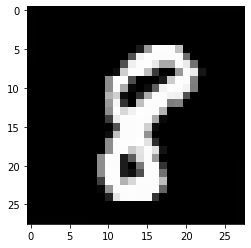

In [ ]:
# sanity check for training data
imgs, lbls = next(iter(train_loader))
imgs[7].data.shape
print("min value", imgs.data.min())
print("max value",imgs.data.max())
print("Mean",imgs.data.mean())
print("Std deviation",imgs.data.std())
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")



Let's visualize a batch of data in a grid using the make_grid function from torchvision. We'll also use the .permute method on the tensor to move the channels to the last dimension, as expected by matplotlib.

In [ ]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


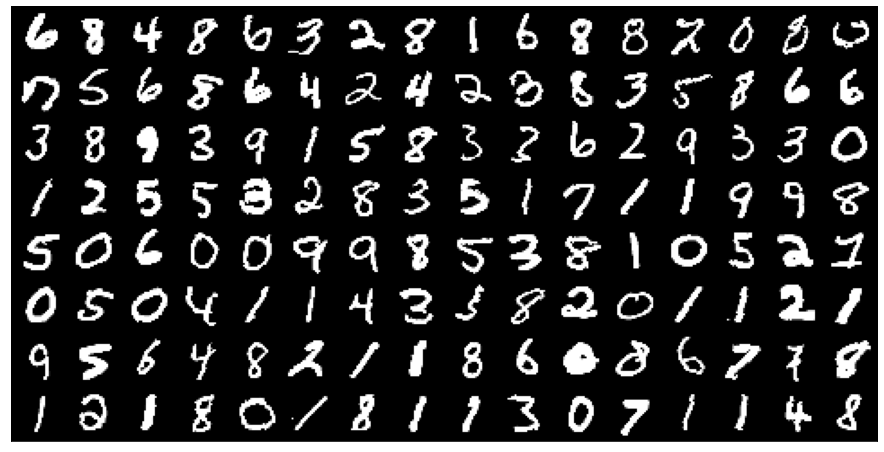

In [ ]:
show_batch(train_loader)


## Evaluation Metric and Loss Function¶
Let's first define out evaluation metric, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the accuracy of the prediction

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


Here we are using torch.max() function, this function's default behaviour as you can guess by the name is to return maximum among the elements in the Tensor. However, this function also helps get the maximum along a particular dimension, as a Tensor, instead of a single element. To specify the dimension (axis – in numpy), there is another optional keyword argument, called dim. This represents the direction that we take for the maximum.

*max_elements, max_indices = torch.max(input_tensor, dim)*

- dim=0, (maximum along columns).
- dim=1 (maximum along rows).

This returns a tuple, max_elements and max_indices.

* max_elements -> All the maximum elements of the Tensor.
* max_indices -> Indices corresponding to the maximum elements.

In the above accuracy function, the == performs an element-wise comparison of two tensors with the same shape, and returns a tensor of the same shape, containing 0s for unequal elements, and 1s for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

## Loss Function
While the accuracy is a great way for us (humans) to evaluate the model, it can't be used as a loss function for optimizing our model using gradient descent, for the following reasons:

It's not a differentiable function. torch.max and == are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

Due to these reasons, accuracy is a great evaluation metric for classification, but not a good loss function. A commonly used loss function for classification problems is the cross entropy,

## How Cross Entropy works
For each output row, pick the predicted probability for the correct label. E.g. if the predicted probabilities for an image are [0.1, 0.3, 0.2, ...] and the correct label is 1, we pick the corresponding element 0.3 and ignore the rest.

Then, take the logarithm of the picked probability. If the probability is high i.e. close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function that also provides good feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). This makes it a good choice for the loss function.

PyTorch provides an efficient and tensor-friendly implementation of cross entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the outputs of the model without converting them into probabilities.

In [ ]:
class MnistModelBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        acc = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_acc = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result,LR):
        print("Epoch [{}] - LR [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch,LR,result['train_loss'], result['val_loss'], result['val_acc']))

## Model
we will use a convolutional neural network, using the nn.Conv2d class from PyTorch.
The 2D convolution is a fairly simple operation at heart: you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

The activation function we'll use here is called a Rectified Linear Unit or ReLU, and it has a really simple formula: relu(x) = max(0,x) i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.

To define the model, we extend the nn.Module class

In [ ]:
class MnistModel(MnistModelBase):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size=3),   #RF - 3x3 # 26x26
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 16, 3),   #RF - 5x5 # 24x24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 32, 3),   #RF - 7x7 # 22x22
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
        )

        # translation layer
        # input - 22x22x64; output - 11x11x32
        self.trans1 = nn.Sequential(
            # RF - 7x7
            nn.Conv2d(32, 20, 1), # 22x22
            nn.ReLU(),
            nn.BatchNorm2d(20),


            # RF - 14x14
            nn.MaxPool2d(2, 2), # 11x11
        )

        self.conv2 = nn.Sequential(
            
            nn.Conv2d(20,20,3,padding=1),   #RF - 16x16 #output- 9x9
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout2d(0.1),

            nn.Conv2d(20,16,3),   #RF - 16x16 #output- 9x9
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            nn.Conv2d(16, 16, 3),   #RF - 18x18 #output- 7x7
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),
        ) 

         
        self.conv3 = nn.Sequential(
            nn.Conv2d(16,16,3),   #RF - 20x20  #output- 5x5
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.1),

            #nn.Conv2d(16,10,1),   #RF - 20x20  #output- 7x7

        )   

        # GAP Layer
        self.avg_pool = nn.Sequential(
            # # RF - 22x22
            nn.AvgPool2d(5)
        )   ## output_size=1  

        self.conv4 = nn.Sequential(
  
            nn.Conv2d(16,10,1),   #RF - 20x20  #output- 7x7

        )  

        
    def forward(self, xb):
        x = self.conv1(xb)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avg_pool(x)
        x = self.conv4(x)

        x = x.view(-1, 10)
        return x

- Adding batch norm increases model efficiency, however the number of parameters will also increase
- Never use ReLU activation function in last layer
- Never use batchnorm in last layer
- overfitting can be avoided by adding dropout layer with some percentage normally 0.1 or 0.2
- Add max pool layer only after the layer starts detecting egdes and gradients, and start forming patters, normally it would be after Receptive field - 11x11. 

### Using a GPU
As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers.

define helper functions

In [ ]:
#function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
# a function that can move data and model to a chosen device.    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


#Finally, we define a DeviceDataLoader class to wrap our existing data loaders and move data to the selected device, 
#as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. 
#All we need is an __iter__ method to retrieve batches of data, and an __len__ method to get the number of batches.

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using DeviceDataLoader.

In [ ]:
device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

### Model Training




In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = OneCycleLR(optimizer, lr, epochs=epochs,steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result,scheduler.get_lr())
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the to_device function to move the model's parameters to the right device.

In [ ]:
# Model (on GPU)
model = MnistModel()
to_device(model, device)

MnistModel(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout2d(p=0.1, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.1, inplace=False)
  )
  (trans1): Sequential(
    (0): Conv2d(32, 20, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), st

Print Summary of the model

In [ ]:
from torchsummary import summary
# print the summary of the model
summary(model, input_size=(1, 28, 28), batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
         Dropout2d-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,320
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 32, 22, 22]           4,640
             ReLU-10           [-1, 32, 22, 22]               0
      BatchNorm2d-11           [-1, 32, 22, 22]              64
        Dropout2d-12           [-1, 32, 22, 22]               0
           Conv2d-13           [-1, 20, 22, 22]             660
             ReLU-14           [-1, 20,

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.10107421875, 'val_loss': 2.3144798278808594}]

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for 5 epochs and look at the results. We can use a relatively higher learning of 0.01.

In [ ]:
history += fit(10, 0.01, model, train_loader, val_loader)


Epoch [0] - LR [[0.002803715222454561]], train_loss: 1.6366, val_loss: 0.5540, val_acc: 0.8942


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch [1] - LR [[0.007607424693710002]], train_loss: 0.3656, val_loss: 0.1001, val_acc: 0.9743
Epoch [2] - LR [[0.009999996706267125]], train_loss: 0.1608, val_loss: 0.0652, val_acc: 0.9799
Epoch [3] - LR [[0.009502353253541814]], train_loss: 0.1184, val_loss: 0.0529, val_acc: 0.9837
Epoch [4] - LR [[0.00811296748245884]], train_loss: 0.1027, val_loss: 0.0427, val_acc: 0.9879
Epoch [5] - LR [[0.006107024284679441]], train_loss: 0.0873, val_loss: 0.0410, val_acc: 0.9878
Epoch [6] - LR [[0.003881825311802684]], train_loss: 0.0775, val_loss: 0.0355, val_acc: 0.9888
Epoch [7] - LR [[0.0018780985106812938]], train_loss: 0.0726, val_loss: 0.0319, val_acc: 0.9898
Epoch [8] - LR [[0.0004927065483738951]], train_loss: 0.0662, val_loss: 0.0298, val_acc: 0.9913
Epoch [9] - LR [[4.329373287369841e-08]], train_loss: 0.0634, val_loss: 0.0294, val_acc: 0.9901


## Plot Metrics

In [ ]:
def plot_scores(history):
#     scores = [x['val_score'] for x in history]
    acc = [x['val_acc'] for x in history]
    plt.plot(acc, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

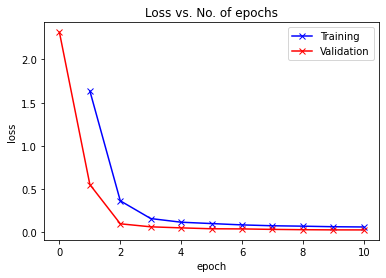

In [ ]:
plot_losses(history)


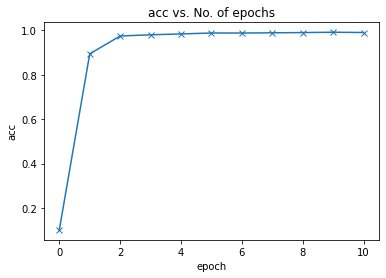

In [ ]:
plot_scores(history)


In [ ]:
def get_misclassified(model, test_loader):
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    # put the model to evaluation mode
    model.eval()
    # turn off gradients

    with torch.no_grad():
        for data, target in test_loader:

            # do inferencing
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(target.view_as(pred)) == False)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target.view_as(pred)[list_misclassified]

            # batch_misclassified =

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)
    # group all the batches together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))

In [ ]:
misclassified = get_misclassified(model, test_loader)


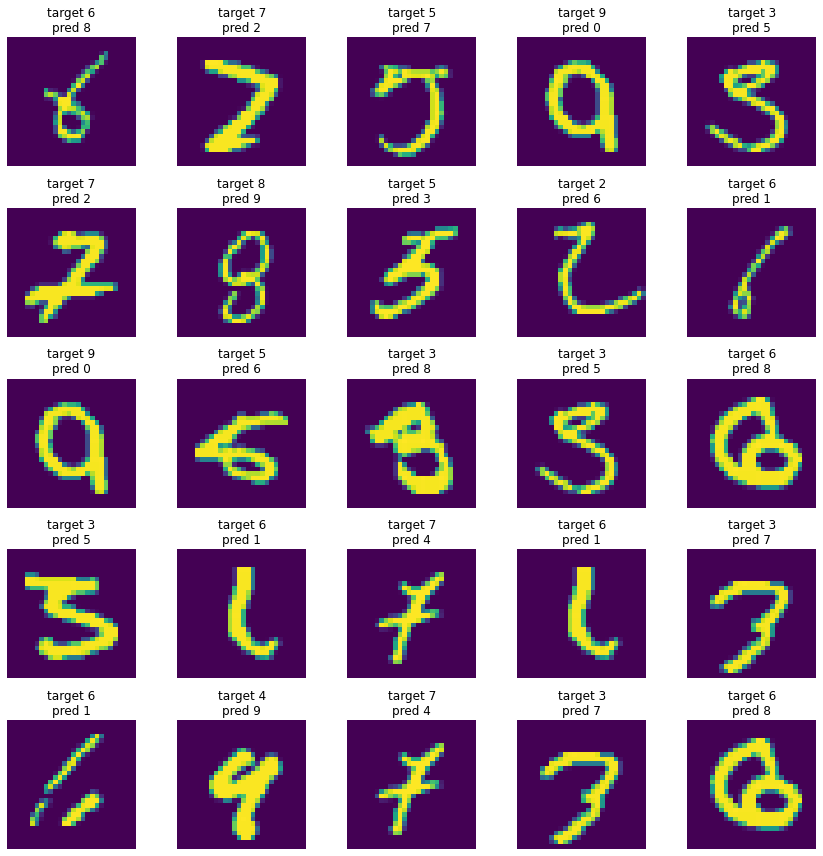

In [ ]:
import random

num_images = 25
fig = plt.figure(figsize=(12, 12))
for idx, (image, pred, target) in enumerate(random.choices(misclassified, k=num_images)):
    image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
    ax = fig.add_subplot(5, 5, idx+1)
    ax.axis('off')
    ax.set_title('target {}\npred {}'.format(target.item(), pred.item()), fontsize=12)
    ax.imshow(image.squeeze())
plt.tight_layout()
plt.show()


### Conclusion

- 99.9% validation accuracy
- 19k parameters
- 10 epochs
- batch norm used
- used dropout after each layer
- no fully connected layer (GAP layer used)